In [1]:
!pip install -U scikit-learn pandas numpy matplotlib seaborn

**Data Understanding & Requirement Analysis**

In [2]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
import pickle

In [4]:
#LOAD DATASET
df = pd.read_csv("credit_risk_dataset.csv")  # upload Kaggle CSV to Colab

df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
#DATA UNDERSTANDING
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nTarget Distribution:\n", df['loan_status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None

Missing Values:
 person_a

**Data Preprocessing & Feature Engineering**

In [6]:
#HANDLE MISSING VALUES (BASIC CLEANING)
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

/tmp/ipython-input-593675952.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
/tmp/ipython-input-593675952.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [7]:
#FEATURE ENGINEERING
# Debt-to-income ratio
df['debt_to_income'] = df['loan_amnt'] / df['person_income']

# Total obligation ratio
df['total_obligation_ratio'] = df['loan_percent_income'] + df['debt_to_income']

# Employment length groups
df['emp_length_group'] = pd.cut(
    df['person_emp_length'],
    bins=[-1, 2, 5, 10, 40],
    labels=['0-2', '3-5', '6-10', '10+']
)

In [10]:
#FEATURE SELECTION

#Numerical Features
numerical_features = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'debt_to_income',
    'total_obligation_ratio'
]
#Categorical Features
categorical_features = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file',
    'emp_length_group'
]

**EXPLORATORY DATA ANALYSIS (EDA)**

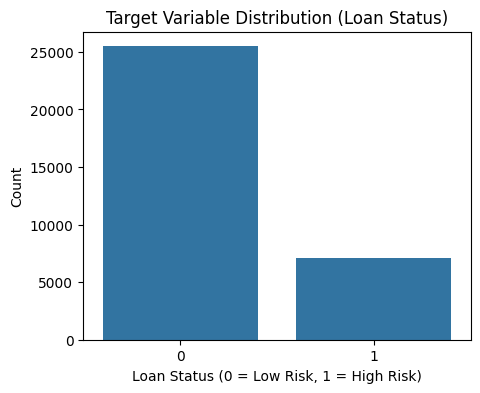

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64


In [11]:
#Target Variable Distribution (Class Imbalance)
plt.figure(figsize=(5,4))
sns.countplot(x='loan_status', data=df)
plt.title("Target Variable Distribution (Loan Status)")
plt.xlabel("Loan Status (0 = Low Risk, 1 = High Risk)")
plt.ylabel("Count")
plt.show()

print(df['loan_status'].value_counts(normalize=True))

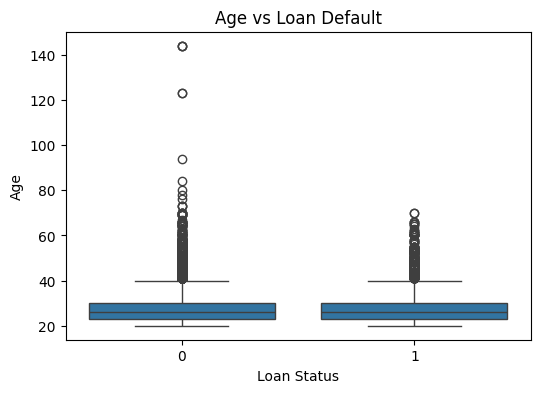

In [12]:
#Age vs Loan Default
plt.figure(figsize=(6,4))
sns.boxplot(x='loan_status', y='person_age', data=df)
plt.title("Age vs Loan Default")
plt.xlabel("Loan Status")
plt.ylabel("Age")
plt.show()

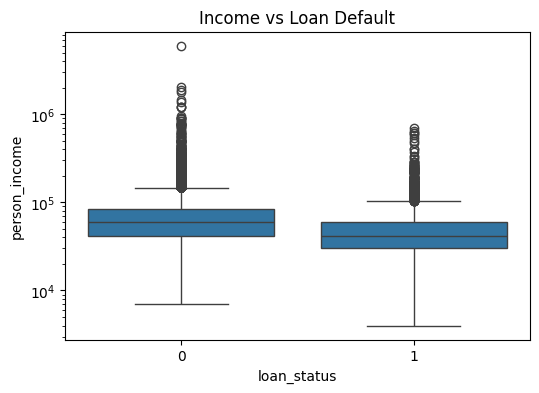

In [13]:
#Income vs Loan Default
plt.figure(figsize=(6,4))
sns.boxplot(x='loan_status', y='person_income', data=df)
plt.title("Income vs Loan Default")
plt.yscale('log')  # income is skewed
plt.show()

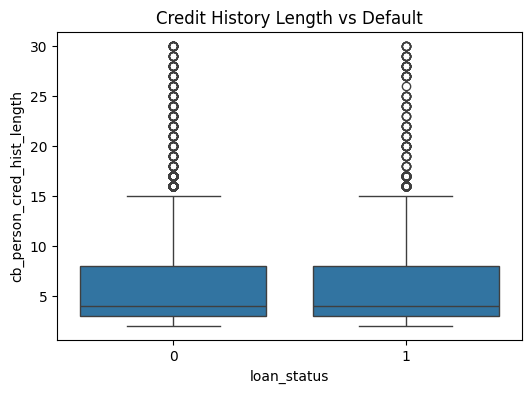

In [14]:
#Credit History Length vs Default
plt.figure(figsize=(6,4))
sns.boxplot(x='loan_status', y='cb_person_cred_hist_length', data=df)
plt.title("Credit History Length vs Default")
plt.show()

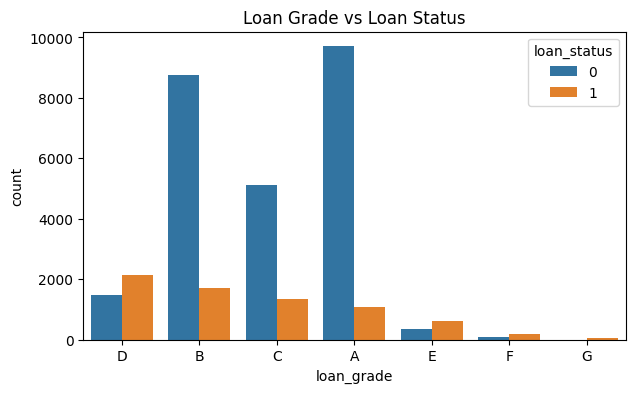

In [15]:
#Loan Grade Distribution by Risk
plt.figure(figsize=(7,4))
sns.countplot(x='loan_grade', hue='loan_status', data=df)
plt.title("Loan Grade vs Loan Status")
plt.show()

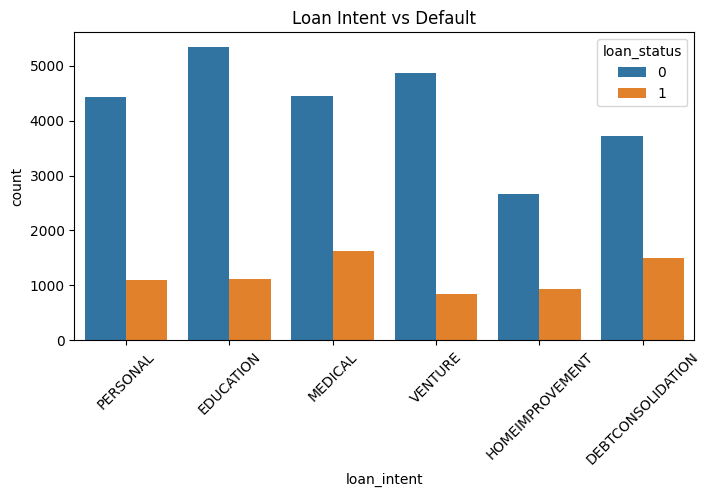

In [16]:
#Loan Intent vs Risk
plt.figure(figsize=(8,4))
sns.countplot(x='loan_intent', hue='loan_status', data=df)
plt.xticks(rotation=45)
plt.title("Loan Intent vs Default")
plt.show()

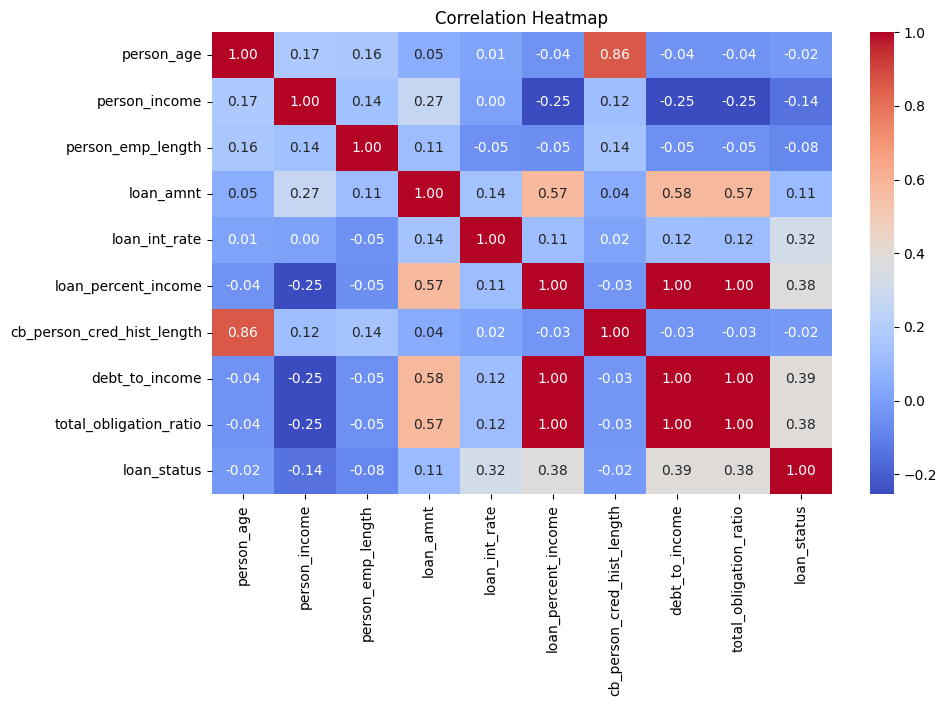

In [17]:
#Correlation Heatmap (Numerical Features)
plt.figure(figsize=(10,6))
sns.heatmap(
    df[numerical_features + ['loan_status']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title("Correlation Heatmap")
plt.show()

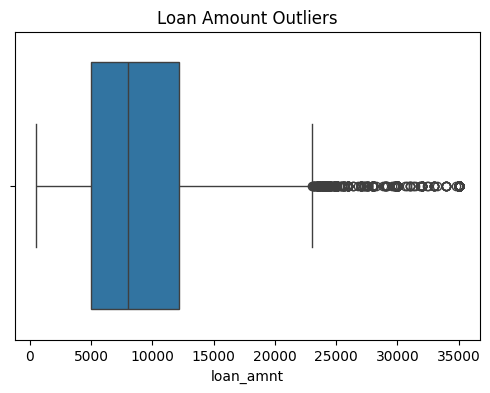

In [18]:
#Outlier Check
plt.figure(figsize=(6,4))
sns.boxplot(x=df['loan_amnt'])
plt.title("Loan Amount Outliers")
plt.show()

In [19]:
#TRAIN–TEST SPLIT
X = df[numerical_features + categorical_features]
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [20]:
#PREPROCESSING PIPELINE
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

**Model Building**

In [21]:
#Define Preprocessing
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

In [22]:
#Define Models to Compare
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear'
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        random_state=42
    ),
    "SVM": SVC(
        kernel='rbf',
        probability=True,
        class_weight='balanced'
    )
}


In [23]:
#Train & Evaluate Models
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": pipeline.score(X_test, y_test),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

In [24]:
#Compare Model Performance
results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
2,Gradient Boosting,0.930183,0.960038,0.709564,0.816013,0.929360
1,Random Forest,0.912383,0.842317,0.736287,0.785741,0.925067
3,SVM,0.886297,0.732741,0.753868,0.743154,0.911601
0,Logistic Regression,0.819242,0.561184,0.786920,0.655152,0.878954


**Model Optimization**

In [25]:
#PROBABILITY CALIBRATION
calibrated_model = CalibratedClassifierCV(
    pipeline,
    method='sigmoid',
    cv=5
)

In [26]:
#TRAIN MODEL
calibrated_model.fit(X_train, y_train)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",Pipeline(step...ility=True))])
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the colum

**Model Evaluation**

In [27]:
y_pred = calibrated_model.predict(X_test)
y_prob = calibrated_model.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5095
           1       0.86      0.70      0.77      1422

    accuracy                           0.91      6517
   macro avg       0.89      0.83      0.86      6517
weighted avg       0.91      0.91      0.91      6517

ROC-AUC Score: 0.9111521043906977


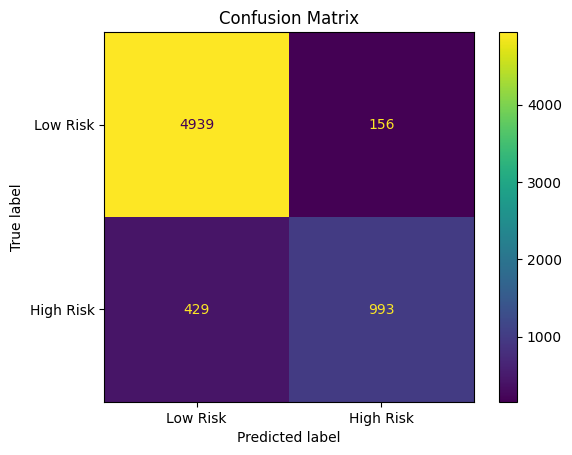

In [28]:
#CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Low Risk', 'High Risk']).plot()
plt.title("Confusion Matrix")
plt.show()

**Model Deployment**

In [29]:
with open("credit_risk_pipeline.pkl", "wb") as f:
    pickle.dump(calibrated_model, f)

In [30]:
import pickle

# Save the fully trained & calibrated pipeline
with open("credit_risk_model.pkl", "wb") as f:
    pickle.dump(calibrated_model, f)

print("Model saved successfully as credit_risk_model.pkl")


Model saved successfully as credit_risk_model.pkl
